#### Part 3 - Jurrasic Fishbach
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

In [1]:
!git clone https://github.com/AlexYoro/CVHW.git
%cd CVHW/HW2/code/

Cloning into 'CVHW'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 362 (delta 11), reused 11 (delta 11), pack-reused 349
Receiving objects: 100% (362/362), 31.96 MiB | 40.15 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/CVHW/HW2/code


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy
import os
import random
from skimage.io import imread
from PIL import Image
import glob

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.

In [2]:
def video_to_image_seq(video_path, output_path ='./datasets/OTB/img/Custom/'):
  '''
  Convert a video file to a sequence of image frames. Saved to a specified directory.
  -----------------------------------------------------------------------------------
  Inputs:
  video_path    |    video file
  output_path   |    directory to where to save the images
  -----------------------------------------------------------------------------------
  Outputs:
  Print the number of frames
  '''
  # read the video file
  os.makedirs(output_path, exist_ok=True)
  video_capture = cv2.VideoCapture(video_path)
  success, image = video_capture.read() 

  count = 0
  print("Converting video to frames...")

  '''
  Save the frames as images
  Example: 
  The first frame of the video will be saved as 0000.jpg, the second frame will be saved as 0001.jpg, and so on.
  '''
  while success:

      fname = str(count).zfill(4)
      cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
      success, image = video_capture.read()
      count += 1

  print("Number of frames: ", count)

Load our video:

In [3]:
video_path = '../data/my_data/my_video/first_try_Trim.mp4'
frames_path = '../data/my_data/output/output_frames/'
os.makedirs(frames_path, exist_ok=True)
video_to_image_seq(video_path,frames_path)

Converting video to frames...
Number of frames:  158


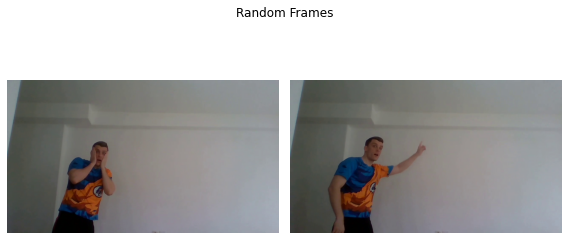

In [8]:
#Load 2 random images and store it as a variables
images = os.listdir(frames_path)
image1 = mpimg.imread(frames_path+random.choice(images))
image2 = mpimg.imread(frames_path+random.choice(images))

# Create a figure with 1 row and 2 columns, and set the title
fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
fig.suptitle('Random Frames')

# Draw the first image on the first subplot
ax[0].imshow(image1)
ax[0].axis('off')

# Draw the second image on the second subplot
ax[1].imshow(image2)
ax[1].axis('off')

# Show the plot
plt.show()

2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.

Using DeepLabV3 segmentation

In [6]:
def deeplab3_segmentation(images_path):
  """
  this function preform semantic segmentation on all images in a given path
  preform with black background and colorpallet
  input
    images_path: path for the dir with all images
  output:
  segmented: a list of segmented images with black background
   segmented_colors: a list of segmented images with colors
  """
  
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  
  #inference mode
  model.eval();

  # define the pre-processing steps  image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  
  frames = [dI for dI in sorted(os.listdir(images_path))] #put all the paths in array
  segmented=[] #will contain the output
  segmented_colors = [] #output colorpalete
  for frame in frames:

    input_image = Image.open(images_path+ frame)
    input_image_array = imread(images_path+ frame)

    # perform pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)
    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    #create a mask to delete background
    masked_seg = np.array(output_predictions.byte().cpu().numpy(), dtype=bool)
    input_image_array[masked_seg == 0 ] = 0
    
    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
     
    segmented_colors.append(r)
    segmented.append(input_image_array)
  return segmented, segmented_colors

In [7]:
segmented_frames,colored_seg_frames = deeplab3_segmentation(frames_path)

Downloading: "https://github.com/pytorch/vision/zipball/v0.5.0" to /root/.cache/torch/hub/v0.5.0.zip
/usr/local/lib/python3.8/dist-packages/torch/hub.py:218: UserWarning: The ref v0.5.0 is ambiguous. Perhaps it is both a tag and a branch in the repo? Torchhub will now assume that it's a branch. You can disambiguate tags and branches by explicitly passing refs/heads/branch_name or refs/tags/tag_name as the ref. That might require using skip_validation=True.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_L

  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
my_video_segmented_path = "../data/my_data/output/video_segmented/"
os.makedirs(my_video_segmented_path, exist_ok=True)

In [9]:
count = 0
for image in segmented_frames:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(my_video_segmented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

print("total frames: ", count)

total frames:  158


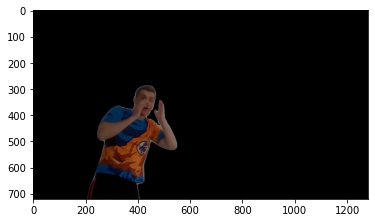

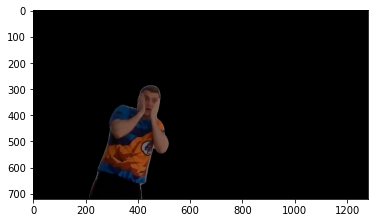

In [10]:
num_of_random = 2

for i in range(num_of_random):
  #segmented object
  random_pick = random.choice([ x for x in segmented_frames])
  # cv2.imwrite(os.path.join(my_video_segmented_path, str(i) + ".jpg"), random_pick)
  imgplot = plt.imshow(random_pick)
  plt.show()

3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?

In [11]:
#UFO
ufo_video = '/content/CVHW/HW2/data/video_models/space_ship.mp4'
ufo_frames_path = '/content/CVHW/HW2/data/my_data/output/UFO_frames/'
ufo_segemented_path = '/content/CVHW/HW2/data/my_data/output/UFO_segmented/'
os.makedirs(ufo_frames_path, exist_ok=True)
os.makedirs(ufo_segemented_path, exist_ok=True)

In [12]:
video_to_image_seq(ufo_video,ufo_frames_path)

converting video to frames...
total frames:  250


In [13]:
def resize_figure(image,scale_percent=60):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image

In [16]:
ufo_segmented,colored_seg_frames = deeplab3_segmentation(ufo_frames_path)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
count = 0
for image in ufo_segmented:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(ufo_segemented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

print("total frames: ", count)

total frames:  250


In [18]:
fixed_ufo=[]
for image in ufo_segmented:
  fixed_ufo.append(255*image)

In [19]:
count = 0
for image in fixed_ufo:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(ufo_segemented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

print("total frames: ", count)

total frames:  250


In [20]:
def plot_rand(num_of_frames, seg_frames):
  for i in range(num_of_frames):
    #segmented object
    random_pick = random.choice([ x for x in seg_frames])
    imgplot = plt.imshow(random_pick)
    plt.show()

In [21]:
def display_im(images):
  """
  display images from the input list
  """
  fig, axes = plt.subplots(1,len(images),figsize=(15,10))
  for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].axis('off')

4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**), and upload it to YouTube (**OPTIONAL**) as instructed above.
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.

In [22]:
def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in glob.glob(os.path.join(imgs_path, '*.jpg')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)

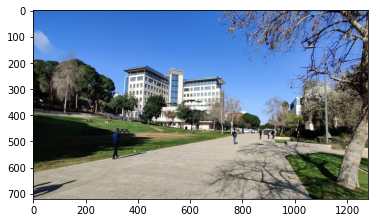

In [35]:
bg = cv2.imread("../data/my_data/my_video/my_background/rsz_technion-campus-haifa-israel-3-scaled.jpg")
bg = cv2.cvtColor(bg,cv2.COLOR_BGR2RGB)
bg2 = cv2.resize(bg, (1280, 720))
plt.imshow(bg2)

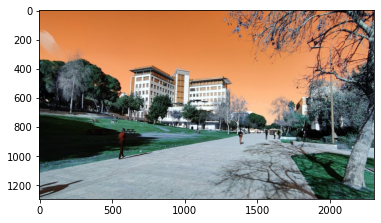

In [36]:
bg2 = cv2.cvtColor(bg2,cv2.COLOR_BGR2RGB)
bg2 = resize_figure(bg2,180)
plt.imshow(bg2)

In [37]:
#myself dims
img1 = cv2.imread('../data/my_data/output/video_segmented/0000.jpg')
img1 = cv2.cvtColor(cv2.rotate(img1,cv2.ROTATE_90_COUNTERCLOCKWISE),cv2.COLOR_BGR2RGB)

print("my image size: {0}".format(img1.shape[:-1]))
print("background size: {0}".format(bg.shape[:-1]))

my image size: (1280, 720)
background size: (720, 1280)


In [38]:
#UFO dims
img2 = cv2.imread('../data/my_data/output/UFO_segmented/0000.jpg')
img2 = cv2.cvtColor(cv2.rotate(img2,cv2.ROTATE_90_COUNTERCLOCKWISE),cv2.COLOR_BGR2RGB)
print("other object size: {0}".format(img2.shape[:-1]))

other object size: (1280, 720)


In [39]:
def put_forground_on_background(background, fore, x=0, y=0):
    back = background.copy()
    rows, cols, channels = fore.shape    
    trans_indices = fore[...,2] != 0 # Where not transparent
    overlay_copy = back[y:y+rows, x:x+cols] 
    valid_indices = np.where(trans_indices)
    #overlay_copy[trans_indices] = fore[trans_indices]
    overlay_copy[valid_indices] = fore[valid_indices]
    back[y:y+rows, x:x+cols] = overlay_copy
    return back

In [40]:
def create_scene(background,frame_path,opp_frame_path,out_path = '../data/my_data/output/scene_frames/'):
  frames = [dI for dI in sorted(os.listdir(frame_path))]
  opp_frame = [dI for dI in sorted(os.listdir(opp_frame_path))]
  scene=[]
  count=0
  for frame in frames:
    count+=1
    img1 = cv2.imread(frame_path +'/'+ frame)

    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    bigger_me = resize_figure(img1,200)
    back = put_forground_on_background(background, bigger_me, 310, 360)
    img2 = cv2.imread(opp_frame_path + '/'+frame)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

    partner= resize_figure(img2,100)
    if (count > 145 ):
      partner= resize_figure(partner,16500/(count*1.3))
      partner = cv2.cvtColor(partner,cv2.COLOR_RGB2HSV)
      partner[:,:,1] = partner[:,:,1] * count/145
      partner[:,:,0] = partner[:,:,0] * count/100
      partner[:,:,2] = partner[:,:,2] * 1.2
      partner = cv2.cvtColor(partner,cv2.COLOR_HSV2RGB)
      partner[:,:,0] = partner[:,:,0] * count/140
      back = put_forground_on_background(back, partner, 1100+count, count)
    else:
      back = put_forground_on_background(back, partner, 800, 400)
    scene.append(back)
  
  os.makedirs(out_path, exist_ok=True)
  count = 0
  for image in scene:
      fname = str(count).zfill(4)
      image = image[:, :, ::-1].copy() 
      cv2.imwrite(os.path.join(out_path, fname + ".jpg"), image)  # save frame as JPEG file 
      count += 1


  return scene

In [41]:
output_frames_path = '../data/my_data/output/scene_frames/' 
os.makedirs(output_frames_path, exist_ok=True)
scene_video_path = '../data/my_data/output/final.mp4'
os.makedirs(scene_video_path, exist_ok=True)

#dancing_man
scene = create_scene(bg2,my_video_segmented_path,ufo_segemented_path,out_path= output_frames_path)

IndexError: ignored